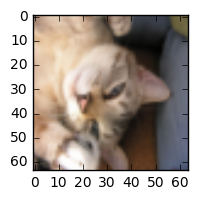

W1= (10, 12288)
b1= (10, 1)
W2= (3, 10)
b2= (3, 1)
W3= (2, 3)
b3= (2, 1)
W4= (1, 2)
b4= (1, 1)
iteration =  0 ;    cost =  0.124358737496
iteration =  500 ;    cost =  0.112912295786
iteration =  1000 ;    cost =  0.112909507441
iteration =  1500 ;    cost =  0.112909506263
iteration =  2000 ;    cost =  0.112909506225
|dW4|<e-8 : 2 / 2
|dW3|<e-8 : 0 / 6
|dW2|<e-8 : 10 / 30
|dW1|<e-8 : 122864 / 122880
iteration =  2500 ;    cost =  0.112909506186
iteration =  3000 ;    cost =  0.112909506148
iteration =  3500 ;    cost =  0.11290950611
iteration =  4000 ;    cost =  0.112909506072
|dW4|<e-8 : 2 / 2
|dW3|<e-8 : 0 / 6
|dW2|<e-8 : 10 / 30
|dW1|<e-8 : 122867 / 122880
iteration =  4500 ;    cost =  0.112909506034
iteration =  5000 ;    cost =  0.112909505996
iteration =  5500 ;    cost =  0.112909505958
iteration =  6000 ;    cost =  0.11290950592
|dW4|<e-8 : 2 / 2
|dW3|<e-8 : 0 / 6
|dW2|<e-8 : 10 / 30
|dW1|<e-8 : 122867 / 122880
iteration =  6500 ;    cost =  0.112909505883
iteration =  70

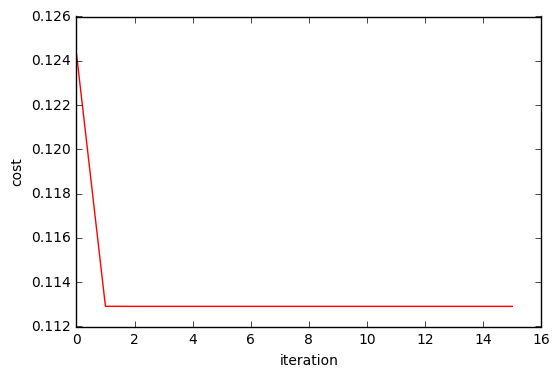

accuracy = 0.34


In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

#字典！以键值对的方式保存的一种数据结构
def load_dataset():
    #1.创建文件对象
    train_dataset = h5py.File('./我的数据集/train_catvnoncat.h5','r')
    test_dataset = h5py.File('./我的数据集/test_catvnoncat.h5','r')
    #2.读取数据
    train_set_x = np.array(train_dataset["train_set_x"][:])
    train_set_y = np.array(train_dataset["train_set_y"][:])
    test_set_x = np.array(test_dataset["test_set_x"][:])
    test_set_y = np.array(test_dataset["test_set_y"][:])
    plt.figure(figsize=(2,2))
    plt.imshow(train_set_x[110])
    plt.show()
    #3.变化维度以适应神经网络输入
    #(209, 64, 64, 3) -> (12288,209)
    train_set_x = train_set_x.reshape(train_set_x.shape[0],-1).T  #(12288,209)
    test_set_x = test_set_x.reshape(test_set_x.shape[0],-1).T  #(12288,209)
    #(209,)->(1,209)
    train_set_y = train_set_y.reshape(1,train_set_y.shape[0]) #(1,209)
    test_set_y = test_set_y.reshape(1,test_set_y.shape[0]) #(1,209)
    
    return train_set_x,train_set_y,test_set_x,test_set_y

def init_parameters(fc_net):
    #1.定义一个字典，存放参数矩阵W1，b1，W2，b2，W3，b3，W4，b4
    parameters = {}
    Layer_num = len(fc_net) #Layer_num=5
    
    for L in range(1,Layer_num):
        parameters["W"+str(L)] = np.random.randn(fc_net[L],fc_net[L-1])*0.01 
        parameters["b"+str(L)] = np.zeros((fc_net[L],1))   
        
    for L in range(1,Layer_num):
        print("W"+str(L)+"=",parameters["W"+str(L)].shape)
        print("b"+str(L)+"=",parameters["b"+str(L)].shape)
                        
    return parameters

def ReLU(Z):
    return np.maximum(0,Z)

def tanh(Z):
    return np.tanh(Z)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def forward_pass(A0,parameters,active_func="ReLU"):    #前向计算函数
    cache ={}
    A = A0
    cache["A0"] = A0
    Layer_num = len(parameters) // 2 #写成/2代表精确除法，得到一个浮点数，写成//2代表向下取整除法，得到一个整数
    for L in range(1,Layer_num): #遍历[1,2,3]
        #z=wx+b
        Z = np.dot(parameters["W"+str(L)],A) + parameters["b"+str(L)] #python的广播机制
        if active_func=="sigmoid":
            A = sigmoid(Z)
        elif active_func=="tanh":
            A = tanh(Z)
        else:
            A = ReLU(Z)
        cache["A"+str(L)] = A
        cache["Z"+str(L)] = Z
        
    Z = np.dot(parameters["W"+str(Layer_num)],A) + parameters["b"+str(Layer_num)] #python的广播机制
    A = sigmoid(Z)
    cache["A"+str(Layer_num)] = A
    cache["Z"+str(Layer_num)] = Z
    return A,cache

def compute_cost(AL,Y):
    m = Y.shape[1]   #Y =（1,209）
    cost = (1/m)*np.sum((1/2)*(AL-Y)*(AL-Y)) #代价函数
    return cost

def backward_pass(AL,parameters,cache,Y,active_func="ReLU"):
    m = Y.shape[1]  #样本总数
    gradient = {}   #保存各层参数梯度的字典
    Layer_num = len(parameters) // 2
    dZL = (AL-Y)*(AL*(1-AL))#获取最末层误差信号 dZL.shape = (1,209)  
    gradient["dW"+str(Layer_num)] = (1/m)*np.dot(dZL,cache["A"+str(Layer_num-1)].T)
    gradient["db"+str(Layer_num)] = (1/m)*np.sum(dZL,axis=1,keepdims = True)    
    for L in reversed(range(1,Layer_num)): #遍历[3,2,1]，其中reversed函数[1,2,3]颠倒为[3,2,1]
        #dZL = np.dot(parameters["W"+str(L+1)].T,dZL)*(AL*(1-AL))  #有问题
        if active_func=="sigmoid":
            dZL = np.dot(parameters["W"+str(L+1)].T,dZL)*(cache["A"+str(L)]*(1-cache["A"+str(L)]))  #dsigmoid/dz  = a*(1-a)
        elif active_func=="tanh":
            dZL = np.dot(parameters["W"+str(L+1)].T,dZL)*(1-np.power(cache["A"+str(L)],2))#dtanh/dz  = 1-a^2
        else:
            dZL = np.dot(parameters["W"+str(L+1)].T,dZL)* np.array(cache["Z"+str(L)]>0) 
        
        gradient["dW"+str(L)] = (1/m)*np.dot(dZL,cache["A"+str(L-1)].T)
        gradient["db"+str(L)] = (1/m)*np.sum(dZL,axis=1,keepdims = True)        
    return gradient

def update_parameters(gradient,parameters,LearnRate):
    #w:=w-lr*dw  ;   b:=b-lr*db
    Layer_num = len(parameters) // 2
    for L in range(1,Layer_num+1): #遍历[1,2,3,4]
        parameters["W"+str(L)] = parameters["W"+str(L)] - LearnRate*gradient["dW"+str(L)]
        parameters["b"+str(L)] = parameters["b"+str(L)] - LearnRate*gradient["db"+str(L)]   
    return parameters

#梯度检验
#解析法：求得梯度解析表达式，通过这个表达式得到梯度（确切解）
#数值逼近：（近似解）
def grad_dict_to_vector(gradient):  #梯度字典转列矩阵
    Layer_num = len(gradient) // 2 #gradients=4
    count = 0
    for L in range(1,Layer_num+1):  #遍历[1,2,...,Layer_num]    
        dW_vector = np.reshape(gradient["dW"+str(L)], (-1,1))  #将该层dW矩阵展平为一个列矩阵 （4,12288）->（49152,1）
        db_vector = np.reshape(gradient["db"+str(L)], (-1,1))  #将该层db矩阵展平为一个列矩阵 （4,1）->（4,1）
        vec_L = np.concatenate((dW_vector, db_vector), axis=0)   #先将该层W个b串联叠加
        if count == 0:
            vec_output = vec_L  #叠加到输出列矩阵
        else:
            vec_output = np.concatenate((vec_output, vec_L), axis=0) #逐层串联叠加
        count = count + 1
    return vec_output #返回列矩阵

def param_dict_to_vector(parameters):#参数字典转列矩阵
    #将我们所有的参数字典转换为满足我们特定所需形状的单个向量。
    Layer_num = len(parameters) // 2 #Layer_num=4	
    count = 0
    for L in range(1,Layer_num+1):  #遍历[1,2,...,Layer_num]    
        W_vector = np.reshape(parameters["W"+str(L)], (-1,1))  #将该层W参数矩阵展平为一个列矩阵   
        b_vector = np.reshape(parameters["b"+str(L)], (-1,1))  #将该层b参数矩阵展平为一个列矩阵 
        vec_L = np.concatenate((W_vector, b_vector), axis=0)   #串联叠加	
        if count == 0:
            vec_output = vec_L
        else:
            vec_output = np.concatenate((vec_output, vec_L), axis=0) #串联叠加
        count = count + 1
    return vec_output

def vector_to_param_dict(vec,param_src):   #列矩阵转参数字典,第一个输入为列矩阵，第二个输入为保存W和b的参数字典
    Layer_num = len(param_src) // 2 #Layer_num=4
    param_epsilon = param_src  
    idx_start = 0
    idx_end = 0
    for L in range(1,Layer_num+1):  #遍历[1,2,...,Layer_num] 
        row = param_src["W"+str(L)].shape[0]
        col = param_src["W"+str(L)].shape[1]
        idx_end = idx_start + row*col #该W参数矩阵元素个数
        #print("idx_start=",idx_start,";idx_end=",idx_end)
        param_epsilon["W"+str(L)] = vec[idx_start:idx_end].reshape((row,col))
        idx_start = idx_end
        
        row = param_src["b"+str(L)].shape[0]
        col = param_src["b"+str(L)].shape[1]
        idx_end = idx_start+row*col #该b参数矩阵元素个数
        #print("b.shape=",param_src["b"+str(L)].shape)
        #print("idx_start=",idx_start,";idx_end=",idx_end)
        param_epsilon["b"+str(L)] = vec[idx_start:idx_end].reshape((row,col))
        idx_start = idx_end
    return param_epsilon #返回添加了epsilon的参数字典    

def gradient_check(A0,Y,gradient,parameters,epsilon=1e-4):
    grad_vec = grad_dict_to_vector(gradient)#梯度字典转列向量
    param_vec = param_dict_to_vector(parameters)#参数字典转列向量(49182,1)
    param_num = param_vec.shape[0]  #49182
    grad_vec_approach = np.zeros(grad_vec.shape)
    for i in range(param_num):
        if i%1000==0:
            print("grad checking i=",i)
        param_vec_plus = np.copy(param_vec)
        param_vec_plus[i][0] = param_vec_plus[i][0] + epsilon
        AL,_ = forward_pass(A0,vector_to_param_dict(param_vec_plus,parameters))
        J_plus_epsilon = compute_cost(AL,Y)
        
        param_vec_minus = np.copy(param_vec)
        param_vec_minus[i][0] = param_vec_minus[i][0] - epsilon
        AL,_ = forward_pass(A0,vector_to_param_dict(param_vec_minus,parameters))
        J_minus_epsilon = compute_cost(AL,Y)

        grad_vec_approach[i][0]= (J_plus_epsilon-J_minus_epsilon)/(2*epsilon)
        
    #在机器学习中，表征两个向量之间差异性的方法：L2范数（欧氏距离）、余弦距离
    #L2范数：主要用于表征两个向量之间数值的差异（适合我们现在的情况）
    #余弦距离：主要用于表征两个向量之间方向的差异
    diff = np.sqrt(np.sum((grad_vec-grad_vec_approach)**2))/(np.sqrt(np.sum((grad_vec)**2))+np.sqrt(np.sum((grad_vec_approach)**2)))
    if diff > 1e-4:
        print("Maybe a mistake in your bakeward pass!!!  diff=",diff)
    else:
        print("No problem in your bakeward pass!!!  diff=",diff)

        """
W1= (4, 12288)
b1= (4, 1)
W2= (3, 4)
b2= (3, 1)
W3= (2, 3)
b3= (2, 1)
W4= (1, 2)
b4= (1, 1)   

def gradient_check(A0,Y,gradient,parameters,check_layer,epsilon=1e-4):
    grad_vec = grad_dict_to_vector(gradient)#梯度字典转列向量
    param_vec = param_dict_to_vector(parameters)#参数字典转列向量(49182,1)
    param_num = param_vec.shape[0]  #49182
    #grad_vec_approach = np.zeros(grad_vec.shape)
    #1.根据指定层数，获取对应层数解析梯度片段
    if check_layer==1:
        start=0
        end=49156
    elif check_layer==2:
        start=49156
        end=49171
    elif check_layer==3:
        start=49171
        end=49179
    elif check_layer==4:
        start=49179
        end=49182
    else:
        start=0
        end=49182
    grad_vec_slice = grad_vec[start:end]
    grad_vec_approach = np.zeros(grad_vec_slice.shape)
    #2.求取数值梯度
    for i in range(start,end):
        if i%1000==0:
            print("grad checking i=",i)
        param_vec_plus = np.copy(param_vec)
        param_vec_plus[i][0] = param_vec_plus[i][0] + epsilon
        AL,_ = forward_pass(A0,vector_to_param_dict(param_vec_plus,parameters))
        J_plus_epsilon = compute_cost(AL,Y)
        
        param_vec_minus = np.copy(param_vec)
        param_vec_minus[i][0] = param_vec_minus[i][0] - epsilon
        AL,_ = forward_pass(A0,vector_to_param_dict(param_vec_minus,parameters))
        J_minus_epsilon = compute_cost(AL,Y)

        grad_vec_approach[i-start][0]= (J_plus_epsilon-J_minus_epsilon)/(2*epsilon)
        
    #3.求距离
    diff = np.sqrt(np.sum((grad_vec_slice-grad_vec_approach)**2))/(np.sqrt(np.sum((grad_vec_slice)**2))+np.sqrt(np.sum((grad_vec_approach)**2)))
    if diff > 1e-4:
        print("Maybe a mistake in your bakeward pass!!!  diff=",diff)
    else:
        print("No problem in your bakeward pass!!!  diff=",diff)
        """
        

        
        
def Train_Net(fc_net,train_set_x,train_set_y,check=False,iterations=2000,LearnRate=0.01,active_func="ReLU"):
    #4.初始化参数
    parameters = init_parameters(fc_net)   
    costs = [] #保存我们每次迭代计算得到的代价值
    for iteration in range(0,iterations):
        AL,cache= forward_pass(train_set_x,parameters,active_func) #AL=(1,209)
        #6.计算代价值
        cost = compute_cost(AL,train_set_y) 
        
        if iteration%500 == 0: #每500个迭代周期打印一次代价值
            print("iteration = ",iteration,";    cost = ",cost)
            costs.append(cost)
        #7.反向传播计算梯度
        gradient = backward_pass(AL,parameters,cache,train_set_y,active_func)
        if check and iteration==2000:
            gradient_check(train_set_x,train_set_y,gradient,parameters)
        #8.根据梯度更新一次参数
        parameters = update_parameters(gradient,parameters,LearnRate)
        
        if iteration>500 and iteration%2000 == 0:
            print("|dW4|<e-8 :",np.sum( abs(gradient["dW4"])<1e-8 ),"/",gradient["dW4"].shape[0]*gradient["dW4"].shape[1])
            print("|dW3|<e-8 :",np.sum( abs(gradient["dW3"])<1e-8 ),"/",gradient["dW3"].shape[0]*gradient["dW3"].shape[1])
            print("|dW2|<e-8 :",np.sum( abs(gradient["dW2"])<1e-8 ),"/",gradient["dW2"].shape[0]*gradient["dW2"].shape[1])
            print("|dW1|<e-8 :",np.sum( abs(gradient["dW1"])<1e-8 ),"/",gradient["dW1"].shape[0]*gradient["dW1"].shape[1])
        
        
    
    plt.plot(costs,'r')
    plt.xlabel("iteration")
    plt.ylabel("cost")
    plt.show()
    return parameters

def Predict(A0,Y,parameters):
    AL,_ = forward_pass(A0,parameters)#AL是（1,50）
    m = AL.shape[1]
    p = np.zeros(AL.shape)
    for i in range(0,AL.shape[1]):
        if AL[0,i]>0.5:
            p[0,i]=1
        else:
            p[0,i]=0           
    accuracy = (1/m)* np.sum(p==Y)
    print("accuracy =",accuracy)
            
    
if __name__ == '__main__':
    #1.加载数据
    train_set_x,train_set_y,test_set_x,test_set_y = load_dataset()
    #2.对输入像素值做归一化（0~255）->(0~1)
    train_set_x = train_set_x/255.
    test_set_x = test_set_x/255.
    #3.定义全连接神经网络各层神经元个数，并初始化参数w和b
    fc_net = [12288,10,3,2,1]       #四层网络（梯度消失）
    #fc_net = [12288,100,1]         #两层网络
    #4.开始训练
    parameters = Train_Net(fc_net,train_set_x,train_set_y,iterations=8000,LearnRate=0.1,active_func="sigmoid") 
    #5.开始预测
    Predict(test_set_x,test_set_y,parameters)
    
    
    
    

    



    